# 4. Clustering and Recommender system

In [2]:
import pandas as pd
import numpy as np

import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer


## 4.1. Prepare the data

In [3]:
df_courses=pd.read_csv('data/cleaned/df_courses.csv', index_col=0)
df_courses.head()

,avg_rating,avg_rating_recent,content_info,description,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,...,published_title,relevancy_score,primary_category,primary_subcategory,published_since_month,rating_1,rating_2,rating_3,rating_4,rating_5
0,4.53965,4.53139,41.0,<p>Interested in the field of Machine Learning...,True,True,950390,All Levels,False,False,...,machinelearning,110.99933,Business,Data & Analytics,29,0.008,0.019,0.100,0.344,0.529
1,4.50200,4.49902,22.5,<p>Are you ready to start your path to becomin...,True,True,903744,All Levels,False,False,...,python-for-data-science-and-machine-learning-b...,110.97737,Business,Data & Analytics,29,0.004,0.009,0.076,0.360,0.551
2,4.48619,4.48952,8.5,<p><strong>Learn how to use SQL quickly and ef...,True,True,762616,All Levels,False,False,...,the-complete-sql-bootcamp,110.94093,Business,Data & Analytics,35,0.007,0.011,0.070,0.340,0.572
3,4.62332,4.62350,7.5,<p>Learn data visualization through Tableau 10...,True,True,937678,All Levels,False,False,...,tableau10,110.91018,Business,Data & Analytics,30,0.004,0.008,0.057,0.322,0.609
4,4.41484,4.41849,49.0,<p><strong>** #1 MOST PURCHASED BUSINESS COURS...,True,True,637930,All Levels,False,False,...,an-entire-mba-in-1-courseaward-winning-busines...,110.90182,Business,Entrepreneurship,38,0.012,0.024,0.120,0.314,0.531


In [4]:
df_reviews=pd.read_csv('data/cleaned/df_reviews.csv', index_col=0)
df_reviews.head()

,course_id,created,rating,user_name
0,950390,2019-02-23T23:23:12Z,4.5,Vikas K
1,950390,2019-02-23T22:52:43Z,4.5,Alicia Kyo
2,950390,2019-02-23T22:52:13Z,2.5,Godfred Narkwa
3,950390,2019-02-23T22:43:44Z,5.0,Moustaine Adegbindin
4,950390,2019-02-23T22:27:37Z,5.0,Krutika Chandrashekhar Pai


### 4.1.1 Pepare the attribute OBJECTIVES

At first I will analyse the column objectives and check the clusters which can be derived from the objectives.

In [5]:
#transform the column objectives into a list 
import ast

df_courses['objectives']=df_courses.objectives.apply(lambda x: ast.literal_eval(x))

In [6]:
tokenizer=RegexpTokenizer(r'[a-zA-Z]+')
stemmer = SnowballStemmer("english")

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

def tokenize_only(text):
    return [word for word in tokenizer.tokenize(text.lower())]

def combine_list(l):
    new_str=""
    for item in l:
        new_str=new_str+' '+str(item) 
    return new_str

In [7]:
objectives_text=df_courses['objectives'].apply(combine_list)
total_stemmed = []
total_tokenized = []
for i in objectives_text:
    obj_stemmed = tokenize(i) 
    total_stemmed.extend(obj_stemmed) 
    
    obj_tokenized = tokenize_only(i)
    total_tokenized.extend(obj_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': total_tokenized}, index = total_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
vocab_frame.head()

there are 536440 items in vocab_frame


,words
master,master
machin,machine
learn,learning
on,on
python,python


In [9]:
#use TfidfVectorizer to 
StopWords=set(stopwords.words('english')+list(punctuation))

vectorizer= TfidfVectorizer(stop_words=StopWords, tokenizer=tokenize, max_features=1000, max_df=0.8)
X=vectorizer.fit_transform(objectives_text)
X.shape

(8834, 1000)

In [10]:
word_features = vectorizer.get_feature_names()
word_features[50:55]

['appear', 'appli', 'applic', 'appreci', 'approach']

### 4.1.2 Prepare the attribute DESCRIPTION

I did the same thing with the description column. The description is a HTML string, so I needed some transformation to remove tags.

In [11]:
import re
tag_re = re.compile(r'<[^>]+>')

def remove_tags(text):
    return tag_re.sub('', text).replace('\n',' ').replace('\xa0',' ').replace('\t',' ')

In [12]:
df_courses['description_text']=df_courses['description'].apply(lambda x : remove_tags(x))
df_courses['description_text'][:3]

0    Interested in the field of Machine Learning? T...
1    Are you ready to start your path to becoming a...
2    Learn how to use SQL quickly and effectively w...
Name: description_text, dtype: object

In [13]:
tokenizer=RegexpTokenizer(r'[a-zA-Z]+')
stemmer = SnowballStemmer("english")

total_stemmed = [] 
total_tokenized = [] 
for i in df_courses['description_text']:
    obj_stemmed = tokenize(i) 
    total_stemmed.extend(obj_stemmed) 
    
    obj_tokenized = tokenize_only(i)
    total_tokenized.extend(obj_tokenized)

In [14]:
vocab_frame_descr = pd.DataFrame({'words': total_tokenized}, index = total_stemmed)
print ('there are ' + str(vocab_frame_descr.shape[0]) + ' items in vocab_frame')
vocab_frame_descr.head()

there are 2961784 items in vocab_frame


,words
interest,interested
in,in
the,the
field,field
of,of


In [15]:
#use TfidfVectorizer to 
StopWords=set(stopwords.words('english')+list(punctuation))

vectorizer_descr= TfidfVectorizer(stop_words=StopWords, tokenizer=tokenize, max_features=1000, max_df=0.8)
X_descr=vectorizer_descr.fit_transform(df_courses['description_text'])
X_descr.shape

(8834, 1000)

In [16]:
word_features_descr = vectorizer_descr.get_feature_names()
word_features_descr[50:55]

['app', 'appli', 'applic', 'approach', 'area']

## 4.2. Clustering with the OBJECTIVES

### 4.2.1. K-Means Clustering - with k=15 clusters

At first I tried to create 15 clusters - there are 16 subcategories, but no need for category 'others'.

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 15, n_init = 10, n_jobs = -1, random_state=1234)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

In [18]:
#top 10 words in each cluster, transform back from stemming
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(vocab_frame.loc[word_features[word]].values.tolist()[0][0] for word in centroid))
    

0 : create, make, get, use, know, write, money, online, work, clients
1 : product, amazon, sell, ebay, profitability, create, find, learning, make, online
2 : book, publish, kindle, ebook, write, amazon, format, create, learning, sell
3 : learning, use, models, machine, understand, build, get, business, create, deep
4 : understand, management, identify, use, processing, development, risks, difference, practices, system
5 : sales, customers, services, prospecting, close, learning, sell, increase, use, understand
6 : investment, cryptocurrency, bitcoin, stocks, understand, estate, buy, trading, learning, real
7 : project, management, agile, plan, understand, learning, risks, schedule, pmp, use
8 : trading, forex, options, learning, strategies, markets, profitability, stocks, understand, use
9 : team, communicate, management, effectively, leadership, skills, motivate, perform, understand, development
10 : students, course, able, end, exam, pmp, learning, understand, questions, completing


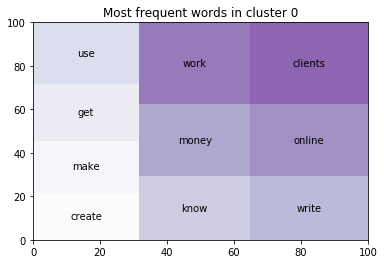

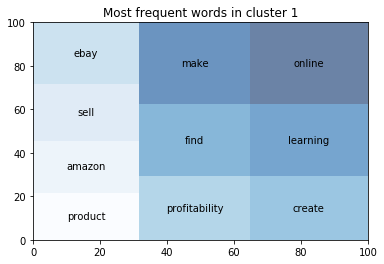

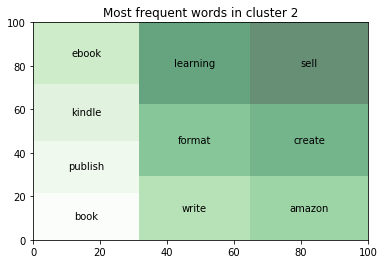

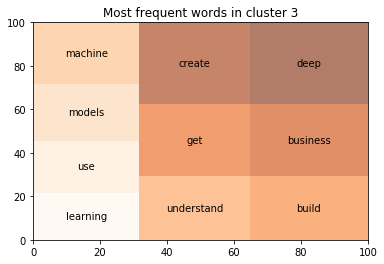

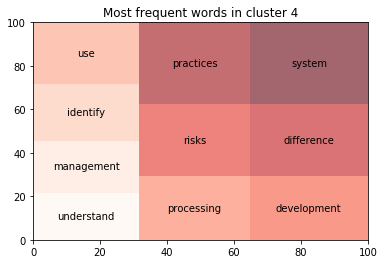

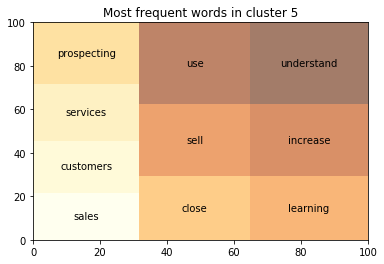

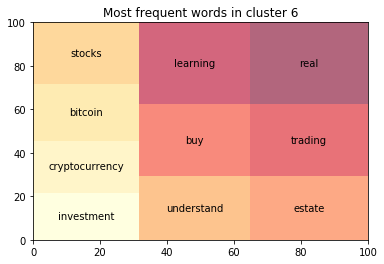

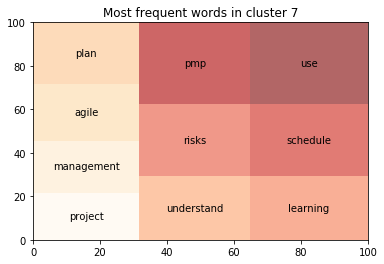

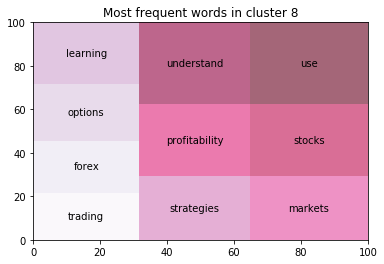

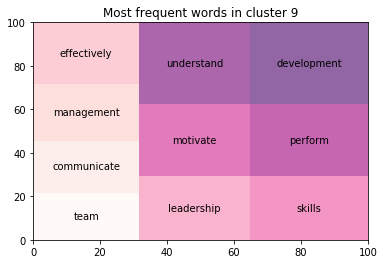

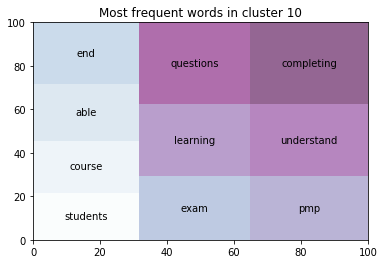

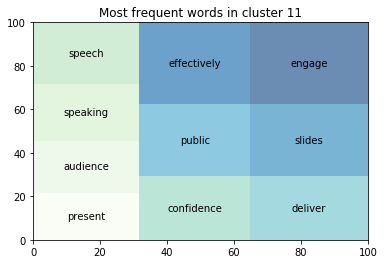

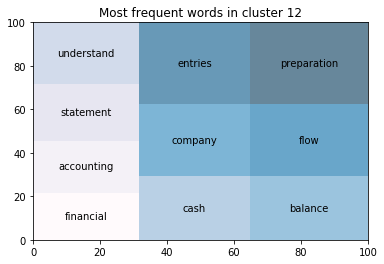

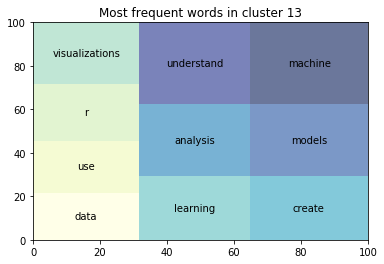

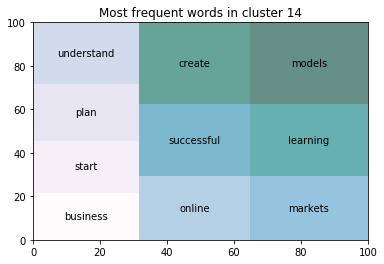

In [19]:
colormaps=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu',
           'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

import matplotlib
import squarify

for num, centroid in enumerate(common_words):
    sizes=np.arange(10,10+len(centroid))
    cmap_name=colormaps[num]
    cmap = plt.get_cmap(cmap_name)
    labels=[vocab_frame.loc[word_features[word]].values.tolist()[0][0] for word in centroid]
    mini=min(sizes)
    maxi=max(sizes)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in sizes]
    squarify.plot(sizes=sizes, label=labels,alpha=0.6, color=colors)
    plt.title("Most frequent words in cluster "+str(num))
    plt.show()
 



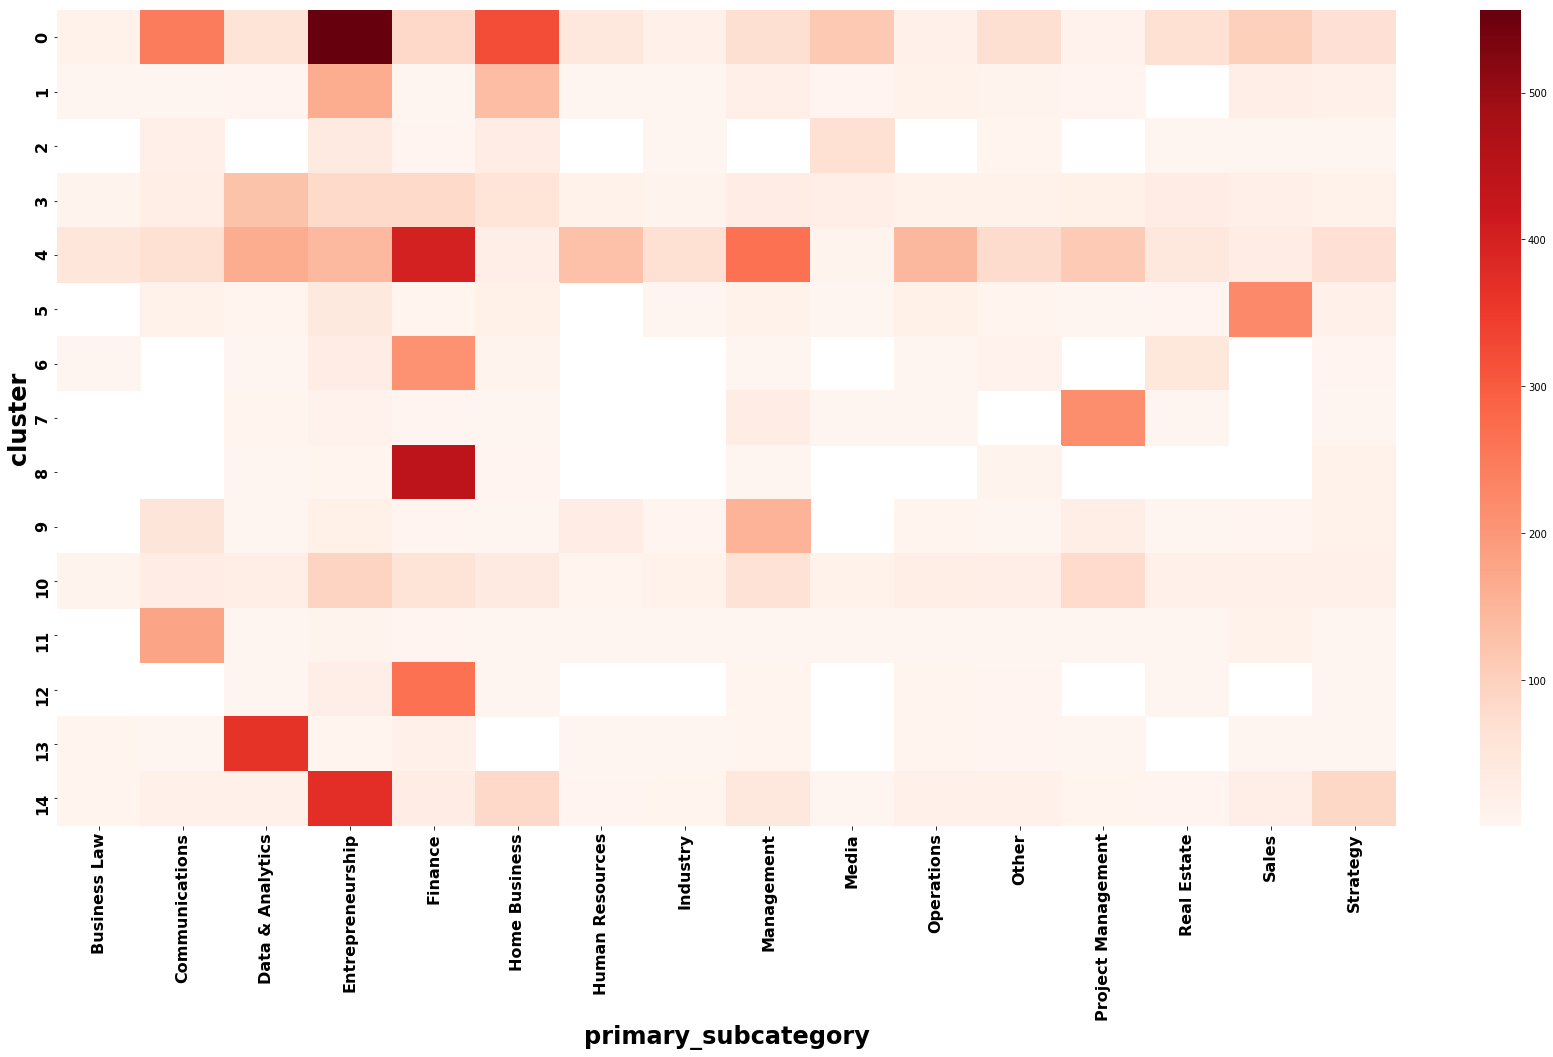

In [20]:
df_courses['cluster']=kmeans.labels_

clusters = df_courses.groupby(['cluster', 'primary_subcategory']).size()
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = 'Reds')

ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
ax.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")


In [21]:
#most of the courses are in cluster 4
df_courses['cluster'].value_counts()

0     1869
4     1808
14     745
3      568
10     528
8      480
13     422
1      409
5      377
9      322
6      321
12     314
7      276
11     218
2      177
Name: cluster, dtype: int64

### 4.2.2. Relationship between number of clusters (k) and inertia

In [22]:
#check other k for the number of clusters

def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(data)
        inertias[i] = model.inertia_
    return inertias

In [23]:
kRange = range(1,30)
testKmean = test(X, kRange)

Text(0.5, 1.0, 'Inertia vs KMean Parameter')

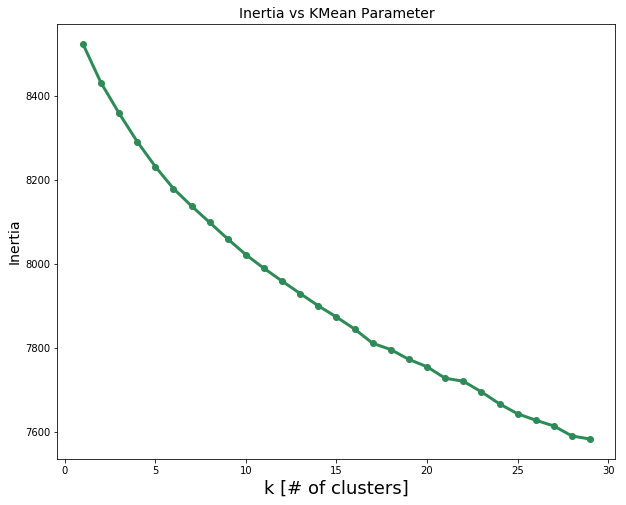

In [24]:
figInertiaWithK = plt.figure(figsize=(10,8))

plt.plot(kRange, testKmean, 'o-', color='seagreen', linewidth=3)
#plt.plot([6], [testKmean[5]], 'o--', color='dimgray', linewidth=3)
#plt.plot([1,6,11], [8520, 8170,7820], '--', color='k', linewidth=1)
#plt.annotate("Let's try k=6", xy=(6, testKmean[5]), xytext=(6,7700),
             #size=14, weight='bold', color='dimgray',
             #arrowprops=dict(facecolor='dimgray', shrink=0.05))
plt.xlabel('k [# of clusters]', size=18)
plt.ylabel('Inertia', size=14)
plt.title('Inertia vs KMean Parameter', size=14)

#figInertiaWithK.savefig('images/kmeans_inertia.png')

### 4.2.3. K-Means with k=6 clusters

It is hard to tell what is the optimal number of clusters from the graph. I tried several number of clusters and finally created 6 clusters with k-Means algorithm

In [25]:
kmeans = KMeans(n_clusters = 6, n_init = 10, n_jobs = -1, random_state=1234)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

In [26]:
#top 10 words in each cluster
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(vocab_frame.loc[word_features[word]].values.tolist()[0][0] for word in centroid))

0 : project, management, agile, understand, plan, learning, risks, use, pmp, schedule
1 : trading, learning, forex, options, markets, stocks, strategies, profitability, understand, use
2 : business, start, understand, plan, learning, successful, markets, create, online, models
3 : data, use, learning, models, r, machine, regression, visualizations, analysis, create
4 : product, sales, learning, sell, create, make, customers, markets, get, online
5 : understand, learning, use, management, course, able, identify, know, financial, work


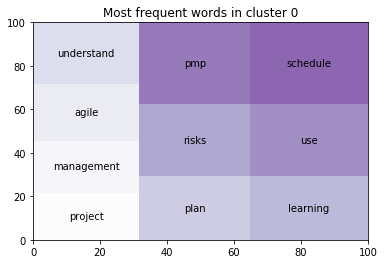

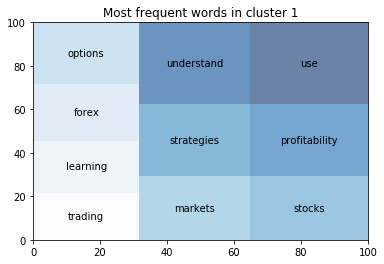

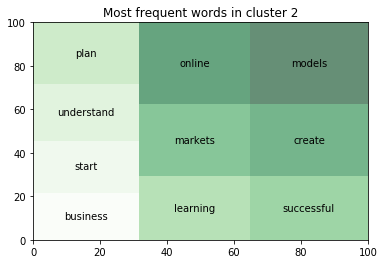

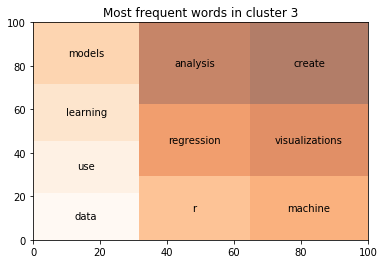

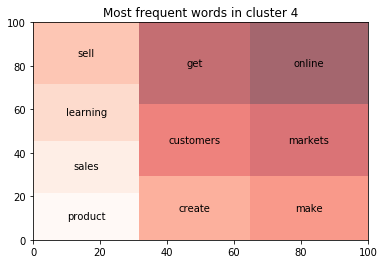

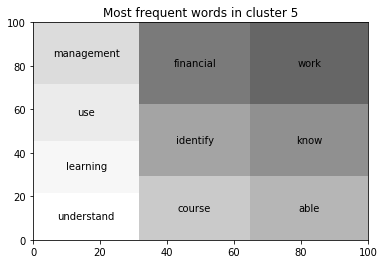

In [27]:
colormaps=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Greys']

import matplotlib
import squarify

for num, centroid in enumerate(common_words):
    sizes=np.arange(10,10+len(centroid))
    cmap_name=colormaps[num]
    cmap = plt.get_cmap(cmap_name)
    labels=[vocab_frame.loc[word_features[word]].values.tolist()[0][0] for word in centroid]
    mini=min(sizes)
    maxi=max(sizes)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in sizes]
    squarify.plot(sizes=sizes, label=labels,alpha=0.6, color=colors)
    plt.title("Most frequent words in cluster "+str(num))
    plt.show()
 


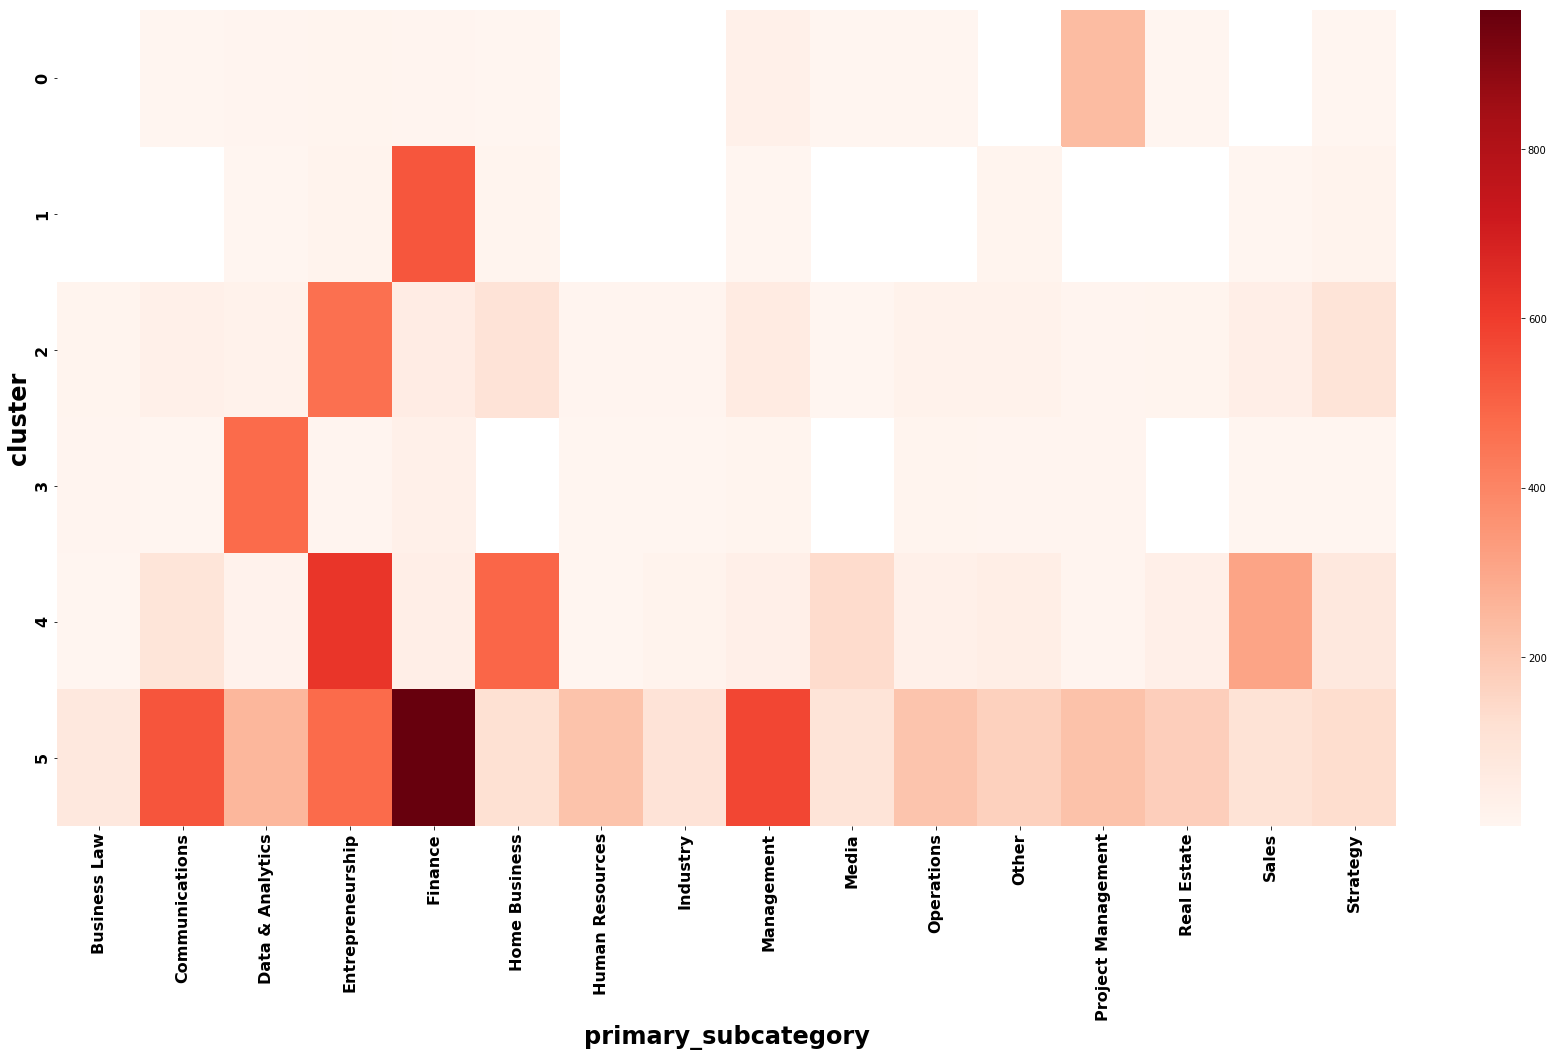

In [28]:
df_courses['cluster']=kmeans.labels_

clusters = df_courses.groupby(['cluster', 'primary_subcategory']).size()
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = 'Reds')

ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
ax.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")


In [29]:
#the distribution of the clusters is very uneven - most of the courses are in cluster 0
df_courses['cluster'].value_counts()

5    4453
4    1957
2     963
1     586
3     564
0     311
Name: cluster, dtype: int64

In [30]:
for i in range(len(df_courses['cluster'].unique())):
    temp=df_courses[df_courses['cluster']==i]
    print(temp['published_title'].values[:5])

['pmp-pmbok6-35-pdus' 'pmp-exam-prep-earn-your-pmp-certification'
 'beginning-project-management-project-management-level-one'
 'pmp-certification-complete' 'pmi_acp_exam_prep']
['forex-trading' 'cryptocurrencytrading' 'learn-options-trading-courses'
 'foundation-course' 'build-your-trading-robot']
['an-entire-mba-in-1-courseaward-winning-business-school-prof'
 'business-analysis-ba' 'the-complete-shopify-aliexpress-dropship-course'
 'the-basics-of-blockchain' 'mba-in-a-box-business-lessons-from-a-ceo']
['machinelearning' 'python-for-data-science-and-machine-learning-bootcamp'
 'the-complete-sql-bootcamp' 'tableau10' 'r-programming']
['become-a-product-manager-learn-the-skills-get-a-job'
 'sell-on-amazon-as-small-start-up' 'sql-for-newbs'
 'ninja-writing-the-four-levels-of-writing-mastery'
 'build-a-shopify-dropshipping-business-from-scratch']
['deeplearning' 'the-complete-financial-analyst-course' 'cryptocurrency'
 'artificial-intelligence-az'
 'the-complete-investment-banking-course-

### 4.2.3. Hierarchical Clustering

In this section I used hierarchical clustering. This method suppose that at the beginning the items have their own clusters
The algorithm starts to merge the individual clusters on by one. 
I created a dendrogram, which shows the distances between the clusters. I plotted the last 16 merges of the hierarchical clustering algorithm.


In [31]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

dist=pdist(X.todense(), metric='euclidean')
z = linkage(dist, 'ward')

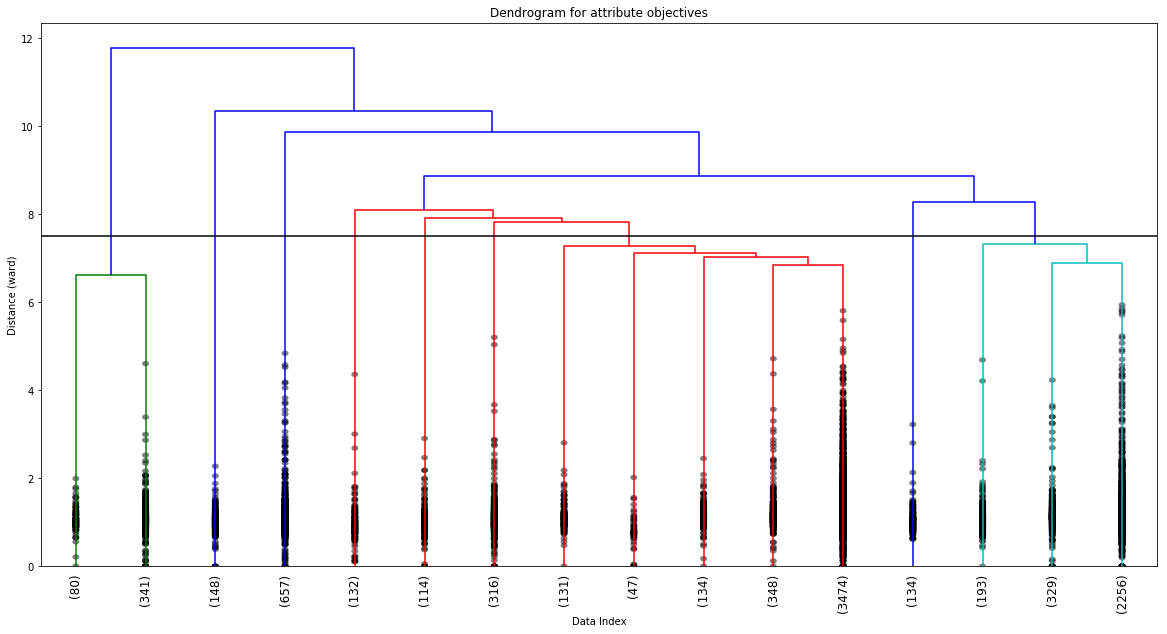

In [32]:
plt.figure(figsize=(20,10))
plt.title('Dendrogram for attribute objectives')
plt.xlabel('Data Index')
plt.ylabel('Distance (ward)')
# p is the number of clusters
# lastp is telling the algorithm to truncate using the number of clusters we set
dendrogram(z, orientation='top', leaf_rotation=90, p=16, truncate_mode='lastp', show_contracted=True);
plt.axhline(7.5, color='k')
#plt.savefig('images/dendrogram.png')

In [33]:
from scipy.cluster.hierarchy import fcluster
#according to the dendrogram, I would cut the graph at 7.5
cluster_hier = fcluster(Z=z, t=7.5, criterion='distance')
cluster_hier.max()

9

In [34]:
df_courses['cluster_hier']=cluster_hier
df_courses['cluster_hier'].value_counts()

7    4134
9    2778
3     657
1     421
6     316
2     148
8     134
4     132
5     114
Name: cluster_hier, dtype: int64

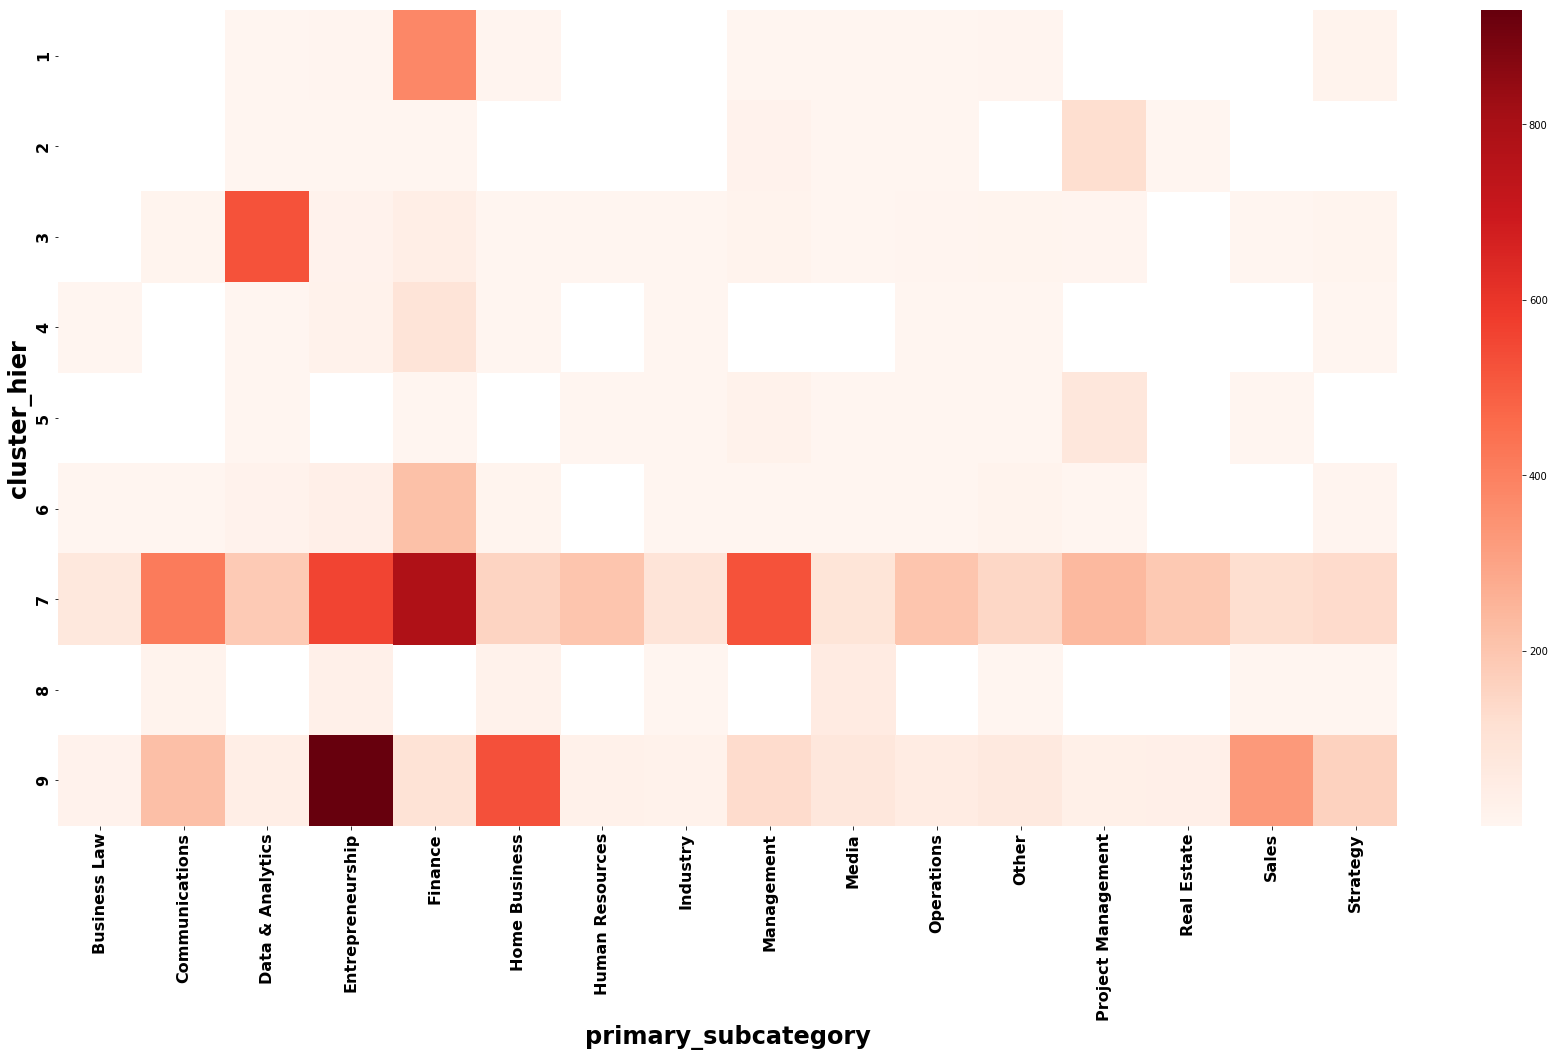

In [35]:

clusters = df_courses.groupby(['cluster_hier', 'primary_subcategory']).size()
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = 'Reds')

ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
ax.set_ylabel('cluster_hier', fontdict = {'weight': 'bold', 'size': 24})
for label in ax.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")


### 4.2.4 PCA for plotting the courses

I will do a simple PCA analysis and keep the first 2 principal components int order to plot the courses in 2D. I will use the results ofthe kmeans clustering (with 6 groups), since the hierarchical clustering resulted in one overproportional group (more than 62% of all courses)

In [36]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2 )
X_2d=pca.fit_transform(X.todense())

In [37]:
df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=kmeans.labels_, title=df_courses['published_title'].values)) 
df.head()

,label,title,x,y
0,3,machinelearning,0.079325,-0.029939
1,3,python-for-data-science-and-machine-learning-b...,0.115547,0.087687
2,3,the-complete-sql-bootcamp,0.008022,0.064520
3,3,tableau10,-0.035516,0.040086
4,2,an-entire-mba-in-1-courseaward-winning-busines...,-0.070555,-0.079337


In [38]:
pca.explained_variance_ratio_.sum()

0.026594966078682555

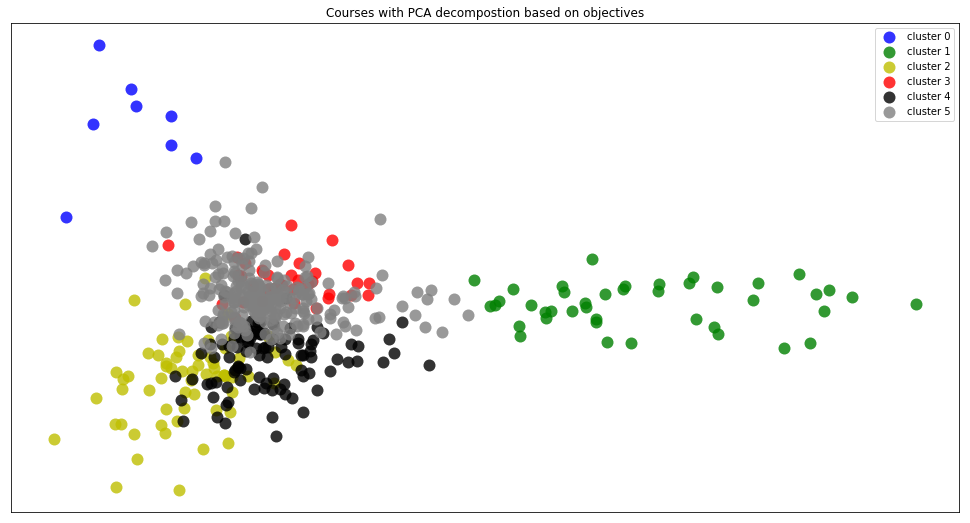

In [39]:
#cluster 1 and 2 are very close
cluster_colors=['b', 'g', 'y','r', 'k', 'grey', 'purple','orange', 'pink', 'brown']
df_sample=df.sample(500)
groups = df_sample.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) 
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=12, 
            label='cluster '+str(name), 
            color=cluster_colors[name], 
            mec='none', alpha=0.8)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',        
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',       
        which='both',    
        left='off',      
        top='off',         
        labelleft='off')
ax.legend(numpoints=1) 
plt.title('Courses with PCA decompostion based on objectives')
plt.savefig('images/clusters_pca.png')
#for i in range(len(df_sample)):
    #ax.text(df_sample.iloc[i,2], df_sample.iloc[i,3], df_sample.iloc[i,1], size=8)  


## 4.3. Clustering with the description

### 4.3.1. K-Means clustering - k=15 clusters

In [40]:
kmeans_descr = KMeans(n_clusters = 15, n_init = 10, n_jobs = -1, random_state=1234)
kmeans_descr.fit(X_descr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

In [41]:
#top 10 words in each cluster, transform back from stemming
common_words = kmeans_descr.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(vocab_frame_descr.loc[word_features_descr[word]].values.tolist()[0][0] for word in centroid))
    

0 : present, speaking, public, audience, speech, skills, speaker, delivered, confidence, learning
1 : accounting, financial, statements, cfo, business, report, company, finance, learning, balance
2 : business, start, planned, successful, entrepreneurs, get, markets, learning, need, ideas
3 : estate, investment, real, properties, stock, investor, markets, learning, money, buying
4 : sales, selling, prospects, customer, close, business, learning, skills, get, clients
5 : illumeo, cpe, platform, com, dozens, credit, certification, two, international, audit
6 : learning, use, manager, understanding, customer, service, business, processing, practical, provides
7 : projects, manager, exam, pmp, pmi, agile, certification, questions, practical, professional
8 : production, online, money, amazon, get, make, selling, business, start, step
9 : trading, traders, forex, stock, options, markets, strategies, profits, learning, charts
10 : write, book, published, writer, kindle, author, ebooks, storie

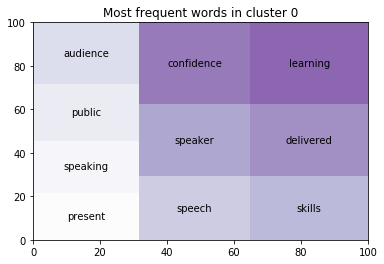

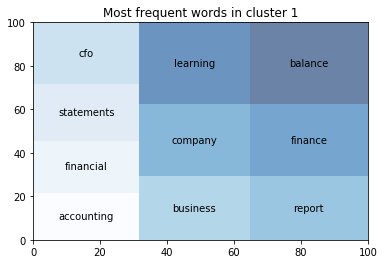

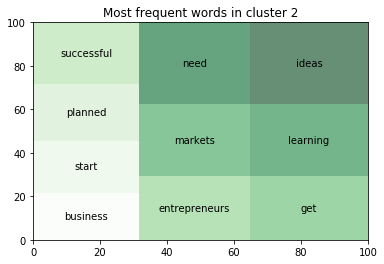

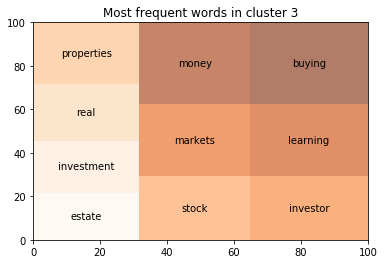

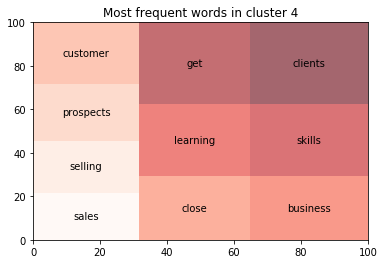

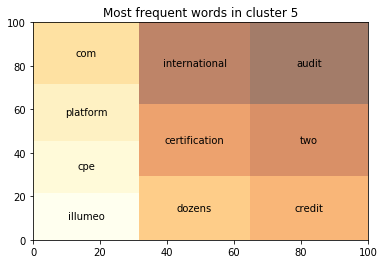

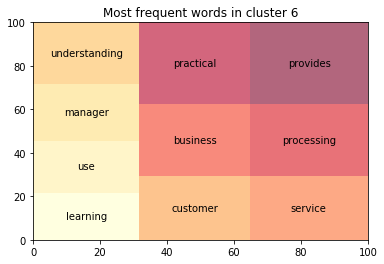

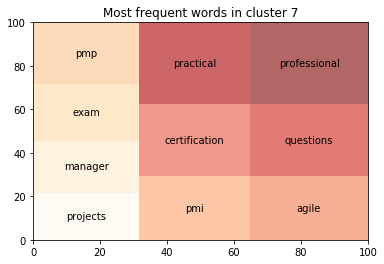

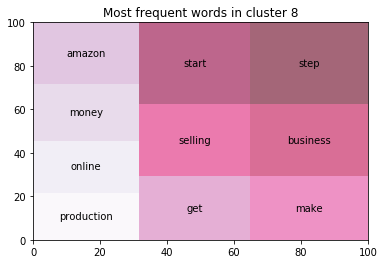

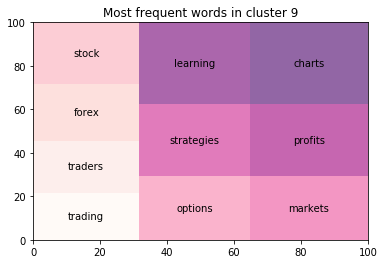

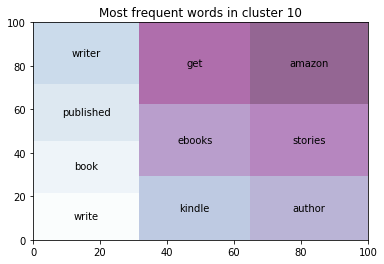

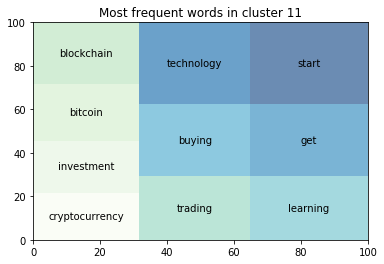

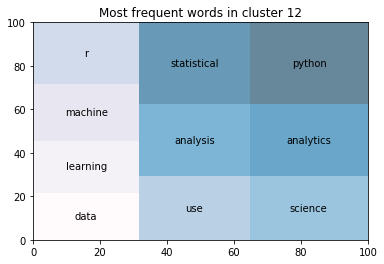

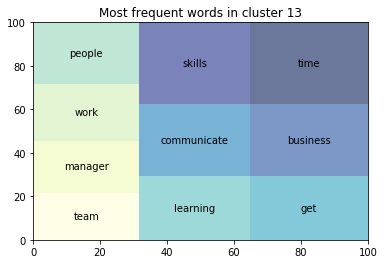

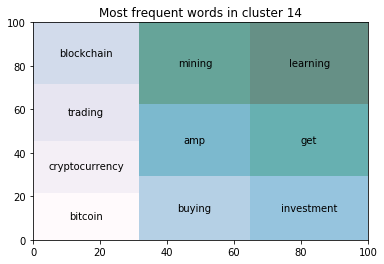

In [42]:
colormaps=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu',
           'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

import matplotlib
import squarify

for num, centroid in enumerate(common_words):
    sizes=np.arange(10,10+len(centroid))
    cmap_name=colormaps[num]
    cmap = plt.get_cmap(cmap_name)
    labels=[vocab_frame_descr.loc[word_features_descr[word]].values.tolist()[0][0] for word in centroid]
    mini=min(sizes)
    maxi=max(sizes)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in sizes]
    squarify.plot(sizes=sizes, label=labels,alpha=0.6, color=colors)
    plt.title("Most frequent words in cluster "+str(num))
    plt.show()
 



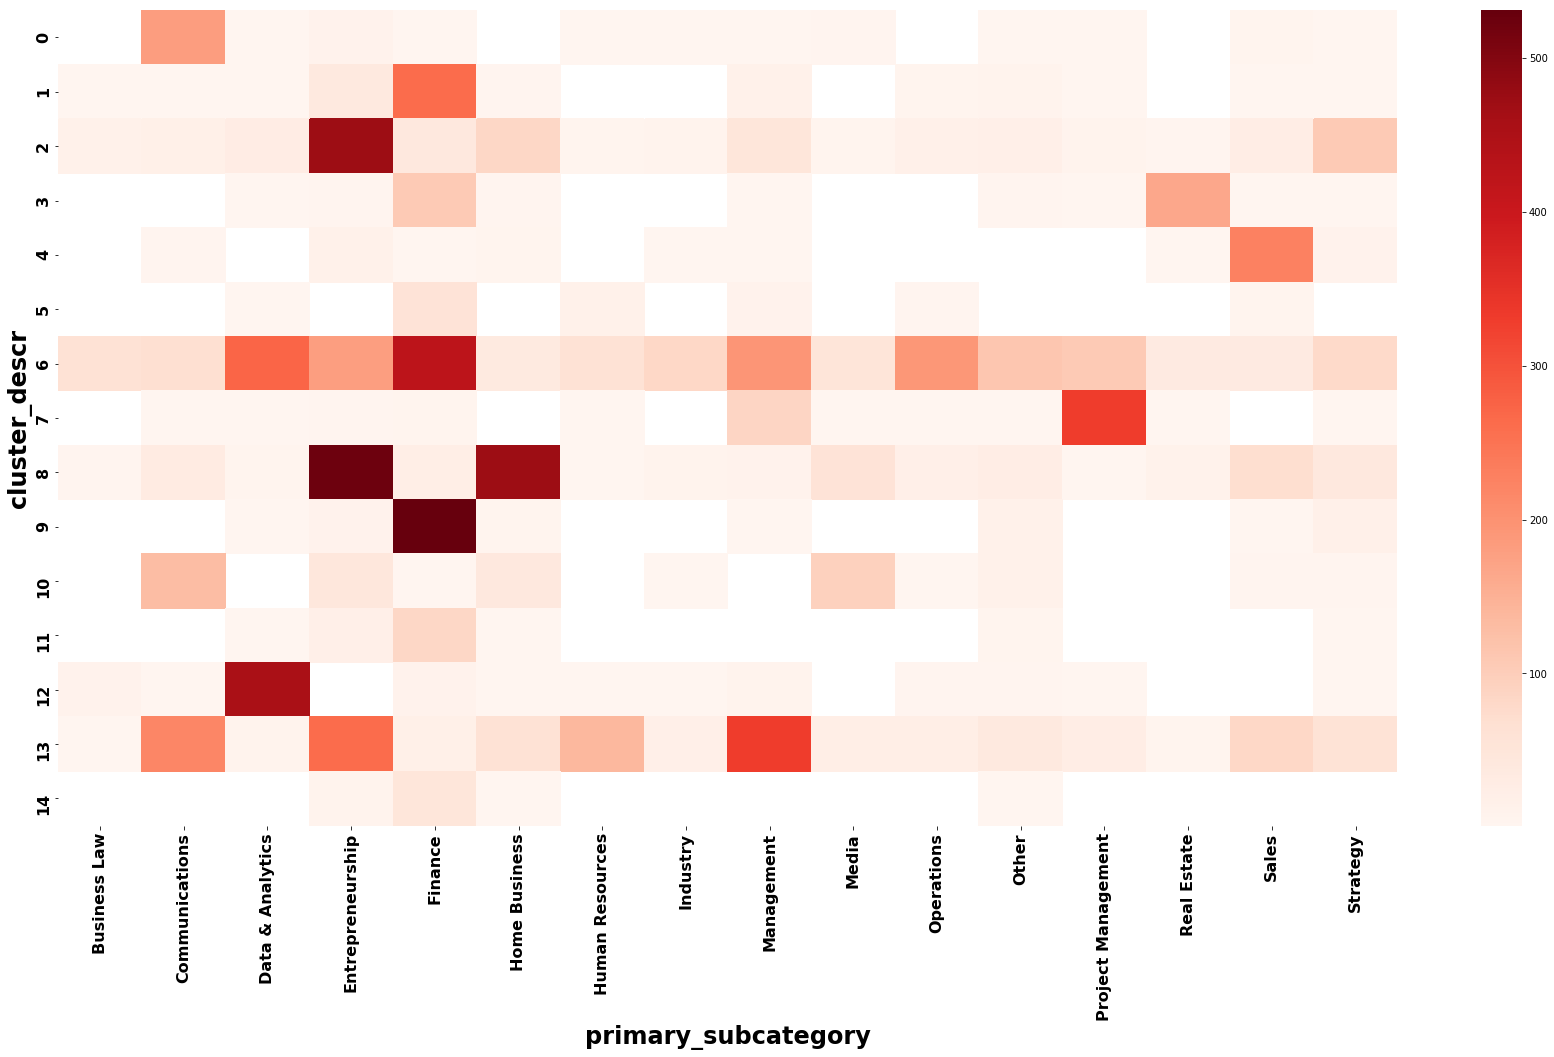

In [43]:
df_courses['cluster_descr']=kmeans_descr.labels_

clusters = df_courses.groupby(['cluster_descr', 'primary_subcategory']).size()
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = 'Reds')

ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
ax.set_ylabel('cluster_descr', fontdict = {'weight': 'bold', 'size': 24})
for label in ax.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")


In [44]:
#most of the courses are in cluster 4
df_courses['cluster_descr'].value_counts()

6     2000
13    1331
8     1314
2      910
9      584
12     503
7      446
1      346
10     342
3      295
4      271
0      216
11     116
5       96
14      64
Name: cluster_descr, dtype: int64

### 4.3.2 Relationship between number of clusters and inertia by the describtion attribute

In [45]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(data)
        inertias[i] = model.inertia_
    return inertias

In [46]:
kRange = range(1,30)
testKmean = test(X_descr, kRange)

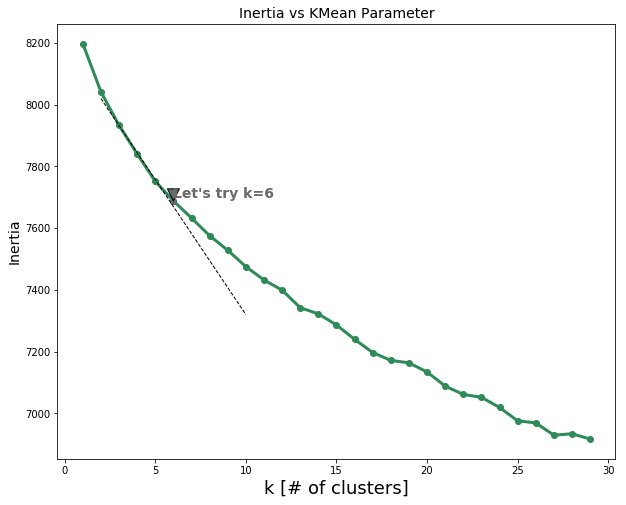

In [81]:
figInertiaWithK = plt.figure(figsize=(10,8))

plt.plot(kRange, testKmean, 'o-', color='seagreen', linewidth=3)
plt.plot([6], [testKmean[5]], 'o--', color='dimgray', linewidth=3)
plt.plot([2,6,10], [8020, 7670,7320], '--', color='k', linewidth=1)
plt.annotate("Let's try k=6", xy=(6, testKmean[5]), xytext=(6,7700),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))
plt.xlabel('k [# of clusters]', size=18)
plt.ylabel('Inertia', size=14)
plt.title('Inertia vs KMean Parameter', size=14)

figInertiaWithK.savefig('images/kmeans_inertia.png')

### 4.3.3. K-MEans with k=6 clusters

In [48]:
kmeans_descr = KMeans(n_clusters = 6, n_init = 10, n_jobs = -1, random_state=123456)
kmeans_descr.fit(X_descr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=123456, tol=0.0001, verbose=0)

In [49]:
#top 10 words in each cluster
common_words = kmeans_descr.cluster_centers_.argsort()[:,-1:-16:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(vocab_frame_descr.loc[word_features_descr[word]].values.tolist()[0][0] for word in centroid))

0 : manager, learning, accounting, use, financial, understanding, work, business, investment, present, skills, help, team, company, get
1 : sales, get, production, selling, make, online, money, amazon, business, write, step, learning, start, book, create
2 : data, learning, machine, r, use, analysis, model, python, science, analytics, statistical, visualizations, regression, tableau, coding
3 : business, start, successful, planned, entrepreneurs, learning, get, markets, need, help, ideas, model, customer, work, make
4 : trading, traders, stock, forex, options, markets, strategies, profits, learning, charts, money, use, analysis, indication, make
5 : projects, manager, exam, pmp, pmi, agile, certification, questions, practical, risk, passed, professional, team, learning, planned


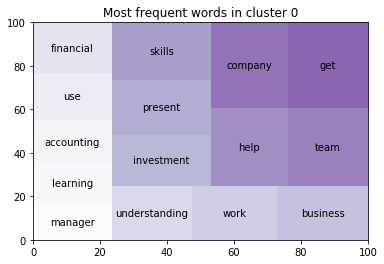

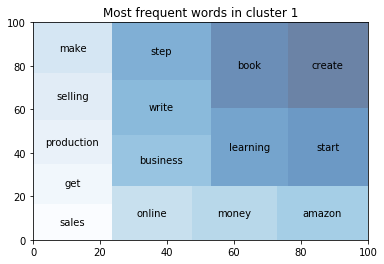

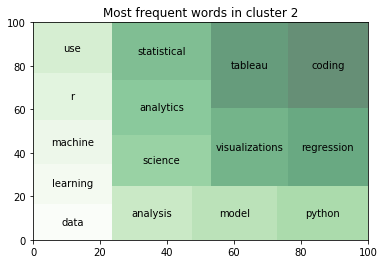

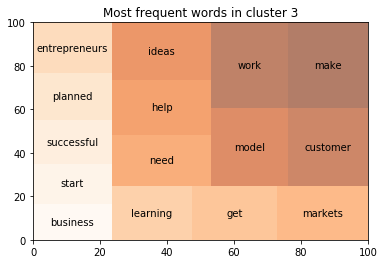

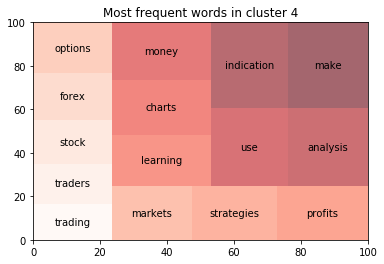

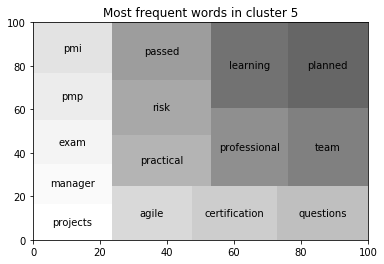

In [50]:
colormaps=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Greys']

import matplotlib
import squarify

for num, centroid in enumerate(common_words):
    sizes=np.arange(10,10+len(centroid))
    cmap_name=colormaps[num]
    cmap = plt.get_cmap(cmap_name)
    labels=[vocab_frame_descr.loc[word_features_descr[word]].values.tolist()[0][0] for word in centroid]
    mini=min(sizes)
    maxi=max(sizes)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in sizes]
    squarify.plot(sizes=sizes, label=labels,alpha=0.6, color=colors)
    plt.title("Most frequent words in cluster "+str(num))
    plt.show()
 

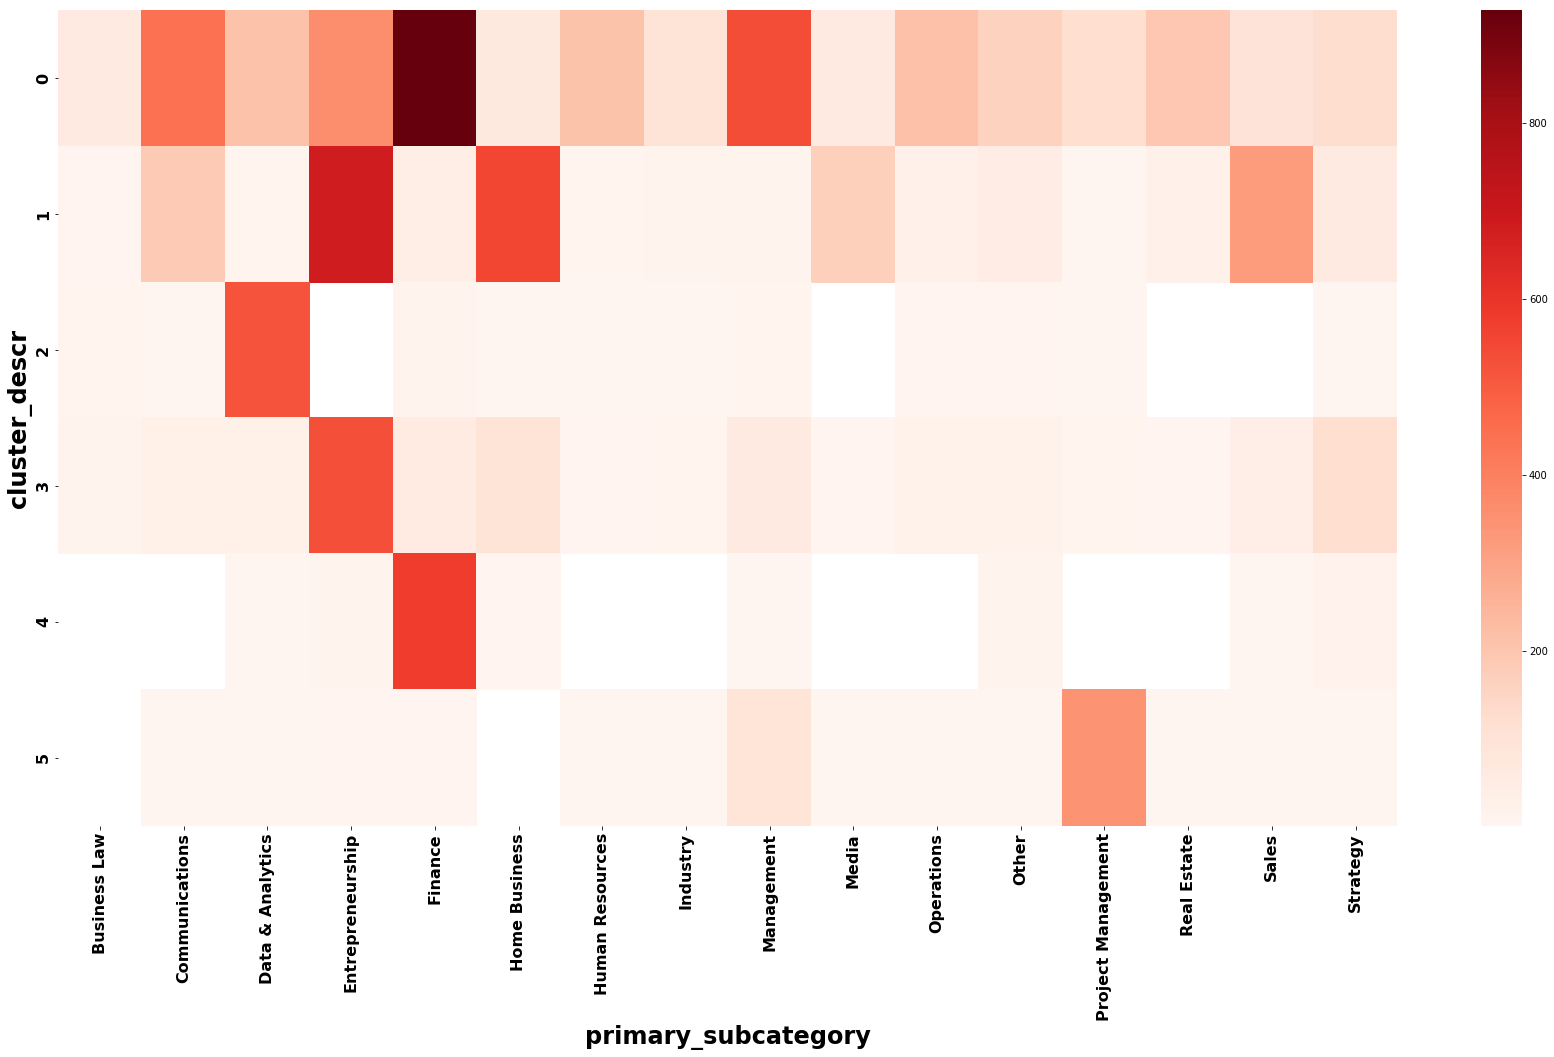

In [51]:
df_courses['cluster_descr']=kmeans_descr.labels_

clusters = df_courses.groupby(['cluster_descr', 'primary_subcategory']).size()
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = 'Reds')

ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
ax.set_ylabel('cluster_descr', fontdict = {'weight': 'bold', 'size': 24})
for label in ax.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")


In [52]:
df_courses['cluster_descr'].value_counts()

0    3916
1    2173
3    1064
4     636
2     576
5     469
Name: cluster_descr, dtype: int64

In [114]:
common_words5 = kmeans_descr.cluster_centers_.argsort()[:,-1:-6:-1]
dict_cluster={}
for num, centroid in enumerate(common_words5):
    dict_cluster[num]=[vocab_frame_descr.loc[word_features_descr[word]].values.tolist()[0][0] for word in centroid]
dict_cluster

{0: ['manager', 'learning', 'accounting', 'use', 'financial'],
 1: ['sales', 'get', 'production', 'selling', 'make'],
 2: ['data', 'learning', 'machine', 'r', 'use'],
 3: ['business', 'start', 'successful', 'planned', 'entrepreneurs'],
 4: ['trading', 'traders', 'stock', 'forex', 'options'],
 5: ['projects', 'manager', 'exam', 'pmp', 'pmi']}

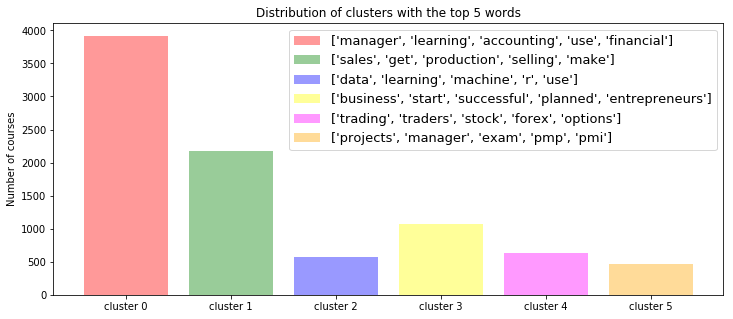

In [120]:
fig, ax=plt.subplots(figsize=(12,5))
keys6=df_courses['cluster_descr'].value_counts().sort_index().index
values6=df_courses['cluster_descr'].value_counts().sort_index().values

colors=['r' , 'g' , 'b' , 'yellow' , 'magenta' , 'orange']

for j in range(len(keys6)):
    ax.bar(keys6[j], values6[j], width=0.8, bottom=0.0, align='center', color=colors[j], alpha=0.4, label=dict_cluster[j])
    
ax.set_xticks(np.arange(len(values6)))
ax.set_xticklabels(['cluster '+str(k) for k in keys6])
ax.set_ylabel('Number of courses')
ax.set_title('Distribution of clusters with the top 5 words')
plt.legend(fontsize=13)
plt.savefig('images/bar_kmeans6_words.png')


In [53]:
for i in range(len(df_courses['cluster_descr'].unique())):
    temp=df_courses[df_courses['cluster_descr']==i]
    print(temp['published_title'].values[:5])

['the-complete-sql-bootcamp' 'r-programming'
 'the-complete-financial-analyst-course'
 'become-a-product-manager-learn-the-skills-get-a-job' 'cryptocurrency']
['sell-on-amazon-as-small-start-up'
 'the-complete-shopify-aliexpress-dropship-course'
 'writing-with-flair-how-to-become-an-exceptional-writer'
 'ninja-writing-the-four-levels-of-writing-mastery'
 'build-a-shopify-dropshipping-business-from-scratch']
['machinelearning' 'python-for-data-science-and-machine-learning-bootcamp'
 'tableau10' 'deeplearning' 'datascience']
['an-entire-mba-in-1-courseaward-winning-business-school-prof'
 'business-analysis-ba' 'mba-in-a-box-business-lessons-from-a-ceo'
 'work-from-home-make-money-turn-experience-into-income'
 'start-and-run-a-successful-web-design-business-from-home']
['forex-trading' 'cryptocurrencytrading' 'learn-options-trading-courses'
 'foundation-course' 'build-your-trading-robot']
['pmp-pmbok6-35-pdus' 'pmp-exam-prep-earn-your-pmp-certification'
 'beginning-project-management-proj

In [54]:
### 4.3.4. Hierarchical clustering

In [55]:

dist_descr=pdist(X_descr.todense(), metric='euclidean')
z_descr = linkage(dist_descr, 'ward')

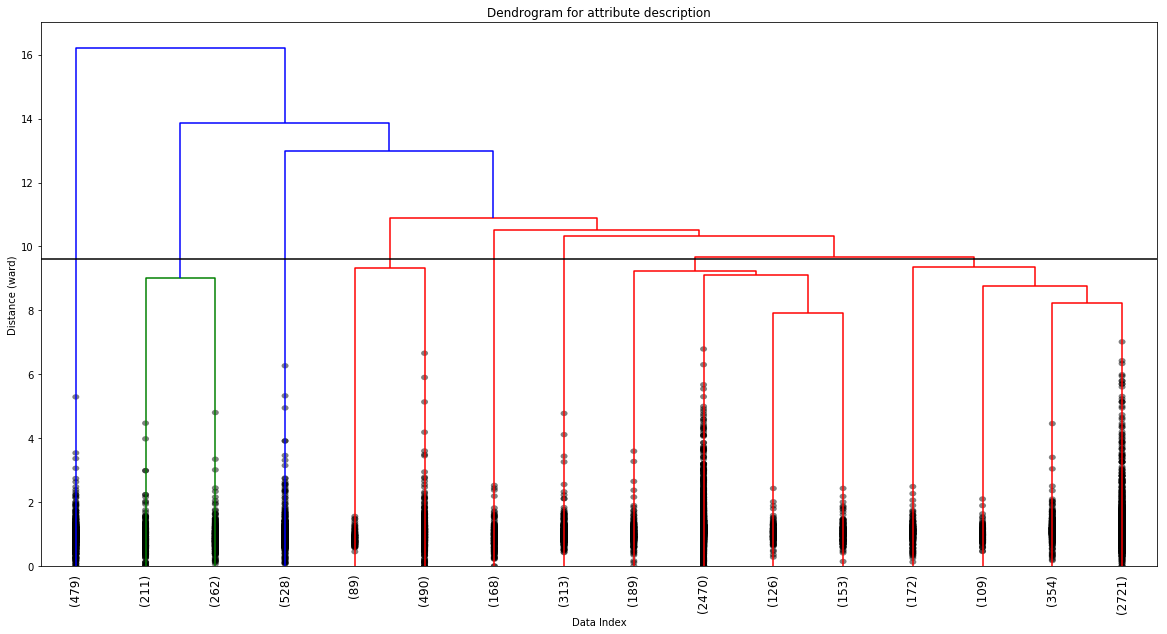

In [56]:
plt.figure(figsize=(20,10))
plt.title('Dendrogram for attribute description')
plt.xlabel('Data Index')
plt.ylabel('Distance (ward)')
# p is the number of clusters
# lastp is telling the algorithm to truncate using the number of clusters we set
dendrogram(z_descr, orientation='top', leaf_rotation=90, p=16, truncate_mode='lastp', show_contracted=True);
plt.axhline(9.6, color='k')
#plt.savefig('images/dendrogram.png')

In [57]:
#according to the dendrogram, I would cut the graph at 7.5
cluster_hier_descr = fcluster(Z=z_descr, t=9.6, criterion='distance')
cluster_hier_descr.max()

8

In [58]:
df_courses['cluster_hier_descr']=cluster_hier_descr
df_courses['cluster_hier_descr'].value_counts()

8    3356
7    2938
4     579
3     528
1     479
2     473
6     313
5     168
Name: cluster_hier_descr, dtype: int64

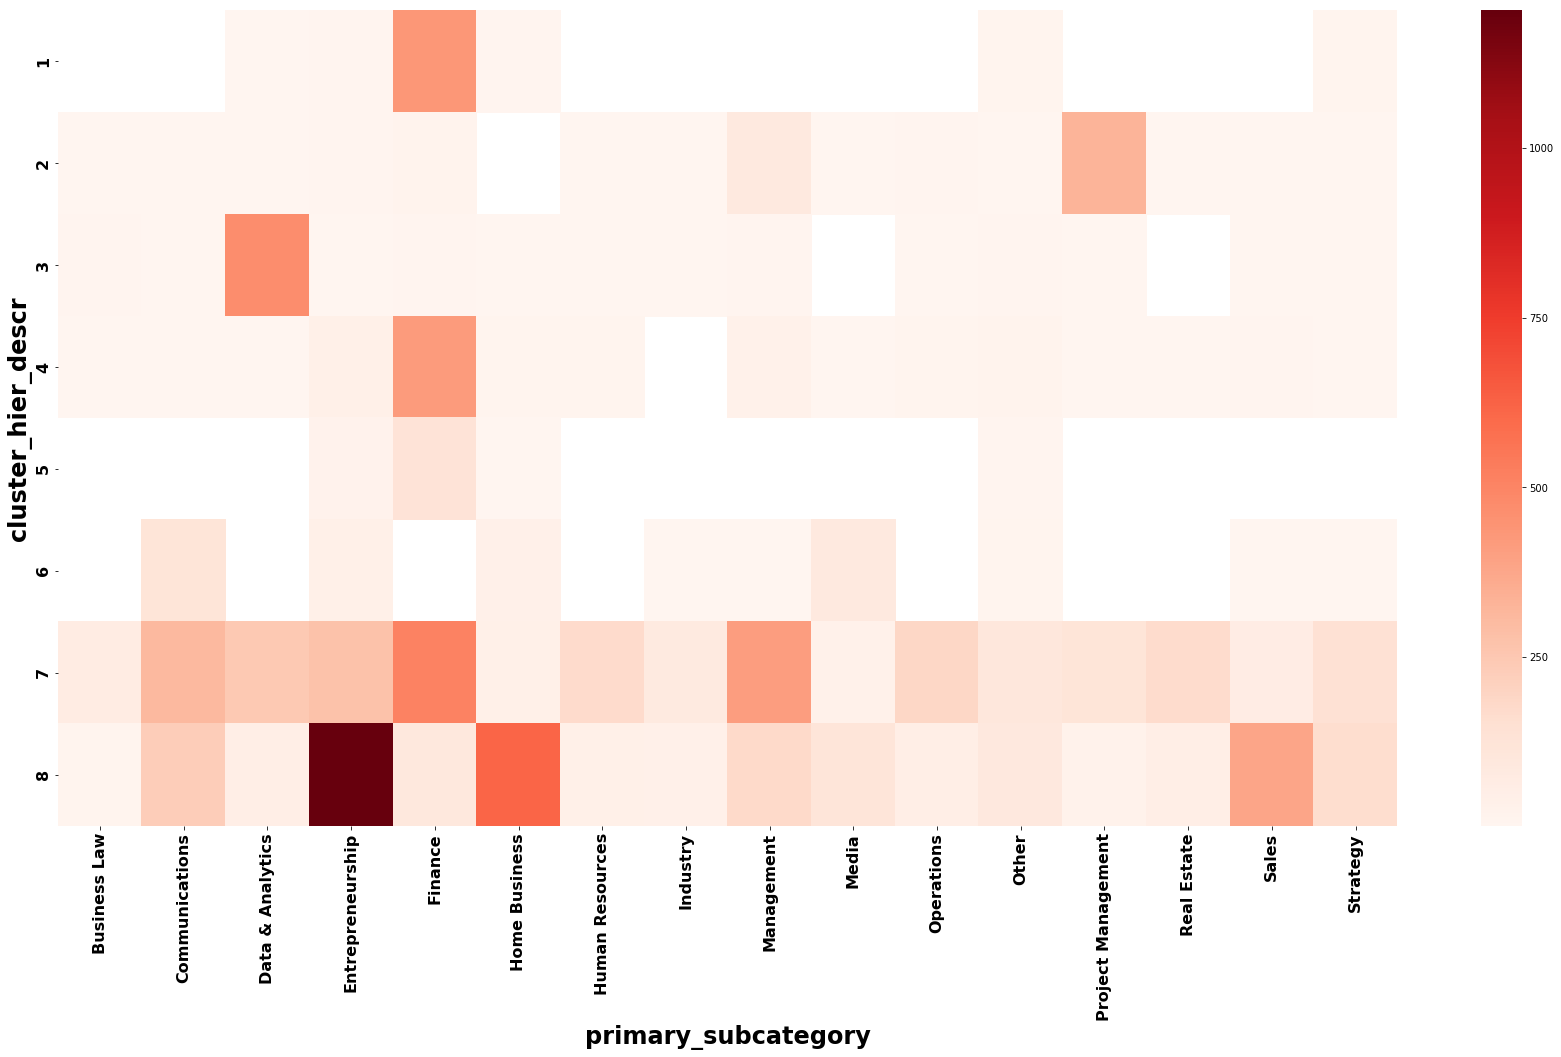

In [59]:

clusters = df_courses.groupby(['cluster_hier_descr', 'primary_subcategory']).size()
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = 'Reds')

ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
ax.set_ylabel('cluster_hier_descr', fontdict = {'weight': 'bold', 'size': 24})
for label in ax.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

### 4.3.5. PCA

In [60]:
pca_descr=PCA(n_components=2 )
X_2d_descr=pca_descr.fit_transform(X_descr.todense())

In [61]:
df_descr = pd.DataFrame(dict(x=X_2d_descr[:,0], y=X_2d_descr[:,1], label=kmeans_descr.labels_, title=df_courses['published_title'].values)) 
df_descr.head()

,label,title,x,y
0,2,machinelearning,-0.048190,0.155770
1,2,python-for-data-science-and-machine-learning-b...,-0.052559,0.212462
2,0,the-complete-sql-bootcamp,-0.031892,0.021047
3,2,tableau10,-0.041203,0.184930
4,3,an-entire-mba-in-1-courseaward-winning-busines...,-0.063105,-0.130523


In [62]:
pca_descr.explained_variance_ratio_.sum()

0.04268454357348075

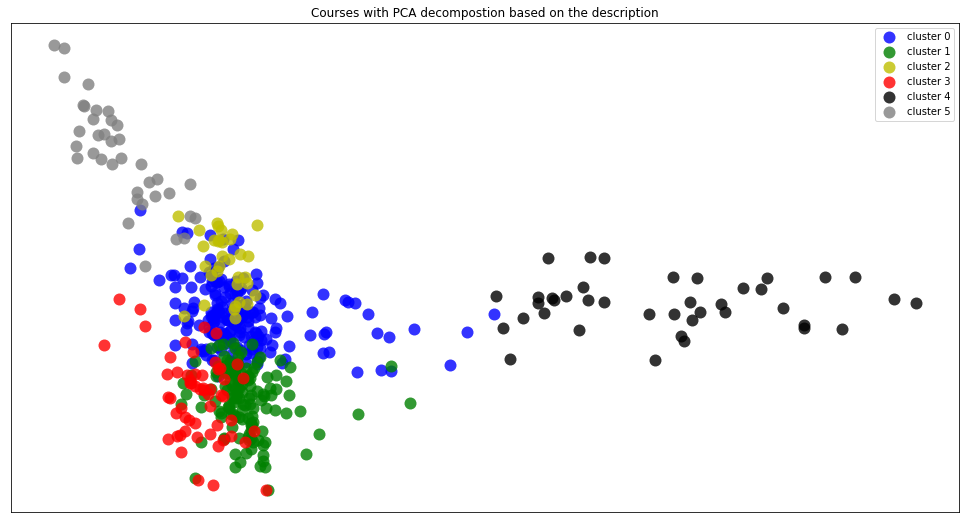

In [63]:
#cluster 1 and 2 are very close
cluster_colors=['b', 'g', 'y','r', 'k', 'grey', 'purple','orange', 'pink', 'brown']
df_sample=df_descr.sample(500, random_state=12345)
groups = df_sample.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) 
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=12, 
            label='cluster '+str(name), 
            color=cluster_colors[name], 
            mec='none', alpha=0.8)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',        
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',       
        which='both',    
        left='off',      
        top='off',         
        labelleft='off')
ax.legend(numpoints=1) 
plt.title('Courses with PCA decompostion based on the description')
plt.savefig('images/clusters_pca.png')
#for i in range(len(df_sample)):
    #ax.text(df_sample.iloc[i,2], df_sample.iloc[i,3], df_sample.iloc[i,1], size=8)  


## 4.4 Building the recommender system

### 4.4.1. Keeping the relevant features

In [121]:
rel_cols=['avg_rating', 'content_info', 'has_certificate',  'instructional_level', 'num_lectures','num_quizzes',
          'num_practice_tests','is_practice_test_course', 'num_article_assets', 'num_curriculum_items',
          'num_subscribers','num_reviews',  'price', 'primary_subcategory','cluster_descr']
df_rel=df_courses[rel_cols]


In [122]:
df_rel.head()

,avg_rating,content_info,has_certificate,instructional_level,num_lectures,num_quizzes,num_practice_tests,is_practice_test_course,num_article_assets,num_curriculum_items,num_subscribers,num_reviews,price,primary_subcategory,cluster_descr
0,4.53965,41.0,True,All Levels,311,8,0,False,27,319,380584,73048,199.99,Data & Analytics,2
1,4.50200,22.5,True,All Levels,151,0,0,False,10,151,192581,37914,194.99,Data & Analytics,2
2,4.48619,8.5,True,All Levels,91,0,0,False,26,91,133919,28313,194.99,Data & Analytics,0
3,4.62332,7.5,True,All Levels,92,7,0,False,2,99,78429,24114,199.99,Data & Analytics,2
4,4.41484,49.0,True,All Levels,89,15,0,False,33,104,187207,23214,199.99,Entrepreneurship,3


In [125]:
df_rel['has_certificate']=df_rel['has_certificate'].astype(int)
#df_rel['is_practice_test_course']=df_rel['is_practice_test_course'].astype(int)
df_rel['cluster_descr']=df_rel['cluster_descr'].astype(str)
dummies=pd.get_dummies(df_rel[['primary_subcategory', 'instructional_level','cluster_descr']], prefix=['subcat', 'level', 'cluster'])
dummies.head()

df_rel.drop(columns=['primary_subcategory', 'instructional_level', 'cluster_descr'], inplace=True)
df_rel=pd.concat([df_rel,dummies], axis=1)
df_rel.head()

,avg_rating,content_info,has_certificate,num_lectures,num_quizzes,num_practice_tests,is_practice_test_course,num_article_assets,num_curriculum_items,num_subscribers,...,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,4.53965,41.0,1,311,8,0,False,27,319,380584,...,1,0,0,0,0,0,1,0,0,0
1,4.50200,22.5,1,151,0,0,False,10,151,192581,...,1,0,0,0,0,0,1,0,0,0
2,4.48619,8.5,1,91,0,0,False,26,91,133919,...,1,0,0,0,1,0,0,0,0,0
3,4.62332,7.5,1,92,7,0,False,2,99,78429,...,1,0,0,0,0,0,1,0,0,0
4,4.41484,49.0,1,89,15,0,False,33,104,187207,...,1,0,0,0,0,0,0,1,0,0


In [126]:
#scale, since the features have different magnitude
from sklearn.preprocessing import StandardScaler
def normalize_features(df):
    df_norm = df.copy()
    for col in df_norm.columns:
        df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))
    return df_norm

In [127]:
df_norm=normalize_features(df_rel)
df_norm.head()

,avg_rating,content_info,has_certificate,num_lectures,num_quizzes,num_practice_tests,is_practice_test_course,num_article_assets,num_curriculum_items,num_subscribers,...,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,0.616257,0.698923,0.154901,6.839941,1.439287,-0.16027,-0.136247,4.579248,6.750430,44.673951,...,0.810425,-0.602022,-0.132316,-0.35728,-0.892333,-0.571163,3.786397,-0.370050,-0.278532,-0.236785
1,0.588610,0.264124,0.154901,2.908008,-0.370114,-0.16027,-0.136247,1.474161,2.764474,22.452616,...,0.810425,-0.602022,-0.132316,-0.35728,-0.892333,-0.571163,3.786397,-0.370050,-0.278532,-0.236785
2,0.577000,-0.064913,0.154901,1.433532,-0.370114,-0.16027,-0.136247,4.396596,1.340918,15.518961,...,0.810425,-0.602022,-0.132316,-0.35728,1.120658,-0.571163,-0.264103,-0.370050,-0.278532,-0.236785
3,0.677699,-0.088416,0.154901,1.458107,1.213112,-0.16027,-0.136247,0.012943,1.530725,8.960226,...,0.810425,-0.602022,-0.132316,-0.35728,-0.892333,-0.571163,3.786397,-0.370050,-0.278532,-0.236785
4,0.524605,0.886945,0.154901,1.384383,3.022513,-0.16027,-0.136247,5.675162,1.649355,21.817427,...,0.810425,-0.602022,-0.132316,-0.35728,-0.892333,-0.571163,-0.264103,2.702338,-0.278532,-0.236785


In [128]:
#calculate similarity with cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances

def recommend_courses(course_id):
    id_=df_courses[df_courses['id']==course_id].index.values
    title=df_courses[df_courses['id']==course_id]['published_title']
    X = df_norm.values
    Y = df_norm.loc[id_].values.reshape(1, -1)
    cos_dist = cosine_similarity(X, Y)
    #eucl_dist = euclidean_distances(X, Y)
    df_sorted=df_courses.copy()
    df_sorted['cosine_distance'] = cos_dist
    #df_sorted['eucl_distance'] = eucl_dist
    df_sorted=df_sorted.sort_values('cosine_distance', ascending=False).reset_index(drop=True)

    return title, df_sorted.iloc[1:6][['published_title', 'cosine_distance']]

In [129]:
def recommend_for_user(user_name):
    list_courses=df_reviews[df_reviews['user_name']==user_name]['course_id'].values
    n_courses=len(list_courses)
    index_courses=df_courses[df_courses['id'].isin(list_courses)].index
    for course_id in list_courses:
        title, df_recommend= recommend_courses(course_id)
        print('The following courses are recommended after taking the course {} with the id {}:'
          .format(title.values[0],course_id))
        print(df_recommend)
        print()
    if n_courses>1:
        df_temp=df_courses.copy()
        for i, course_id in enumerate(list_courses):
            id_=df_courses[df_courses['id']==course_id].index.values
            X = df_norm.values
            Y = df_norm.loc[id_].values.reshape(1, -1)
            cos_dist = cosine_similarity(X, Y)
            df_temp[i] = cos_dist
        temp_sum=df_temp.iloc[:,-n_courses:].sum(axis=1).values
        df_temp['sum_cos_sim']=temp_sum
        df_temp.drop(index=index_courses, inplace=True)
        df_temp=df_temp.sort_values('sum_cos_sim', ascending=False).reset_index(drop=True)
        print('The following courses are recommended after all taken courses:')
        print(df_temp.iloc[1:6][['published_title', 'sum_cos_sim']])

In [130]:
nr_user=df_reviews['user_name'].value_counts()
unique, counts = np.unique(nr_user, return_counts=True)
#dict(zip(unique, counts))
#recommend_for_user(user_name)

In [140]:
nr_user.sort_values()[:10]

Lori Heemann                    1
Alkhader Ali Alkhader Bahath    1
Carlos Perez Pradells           1
Stuart Lenig                    1
Eldor Parmanov                  1
Arhan Wadhwani                  1
Josh Clements                   1
DEEPAK IYER                     1
Quek Wei Kin                    1
Wille Dahl                      1
Name: user_name, dtype: int64

In [152]:
recommend_for_user('DEEPAK IYER')


The following courses are recommended after taking the course scala-and-spark-for-big-data-and-machine-learning with the id 977062:
                                     published_title  cosine_distance
1  microsoft-power-bi-up-running-with-power-bi-de...         0.970948
2                                      mastertableau         0.970348
3                machine-learning-course-with-python         0.938711
4                                          mspowerbi         0.936760
5                                sascompletetutorial         0.935890



In [133]:
recommend_for_user('Henk Bergsma')


The following courses are recommended after taking the course machinelearning with the id 950390:
                                     published_title  cosine_distance
1  python-for-data-science-and-machine-learning-b...         0.996464
2                          the-complete-sql-bootcamp         0.984931
3                                      r-programming         0.975774
4                                          tableau10         0.958699
5                                        datascience         0.954472

The following courses are recommended after taking the course artificial-intelligence-az with the id 1219332:
                                     published_title  cosine_distance
1                                       deeplearning         0.963018
2                                      python-coding         0.936505
3                          the-complete-sql-bootcamp         0.921200
4                                      r-programming         0.920673
5  an-entire-mba-in-1